In [1]:
import scipy.io as spio
import numpy as np

In [2]:
X = spio.loadmat(file_name='../data/bci-sample-data/x.mat')

In [3]:
Y = spio.loadmat(file_name='../data/bci-sample-data/y.mat')

In [4]:
Data = X['Intensification_Data']
SType = Y['Intensification_SType'].mean(axis=1)

In [5]:
(Data.shape, SType.shape, Data.dtype, SType.dtype)

((6480, 192, 64), (6480,), dtype('<f8'), dtype('float64'))

In [6]:
# 30 % total data test
# 70 % total data train+valid
length = int(Data.shape[0] * 0.30)
length

1944

In [7]:
TrainDataAll = Data[:-length]
TestData = Data[-length:]

In [8]:
TrainDataAll.shape, TestData.shape

((4536, 192, 64), (1944, 192, 64))

In [9]:
# 30% total train data is valid
# 70% total trainALl is training
length2 = int(TrainDataAll.shape[0] * 0.30)
length2

1360

In [10]:
TrainData = TrainDataAll[:-length2]
ValidData = TrainDataAll[-length2:]

In [11]:
TrainData.shape, ValidData.shape

((3176, 192, 64), (1360, 192, 64))

In [12]:
# Normalizing input data
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [13]:
# Standardize/normalize train and test
X_train_norm = normalize(inputs=TrainData)
X_valid_norm = normalize(inputs=ValidData)
X_test_norm = normalize(inputs=TestData)

In [14]:
(X_train_norm.shape, X_train_norm.dtype, 
X_valid_norm.shape, X_valid_norm.dtype,
X_test_norm.shape, X_test_norm.dtype)

((3176, 192, 64),
 dtype('<f8'),
 (1360, 192, 64),
 dtype('<f8'),
 (1944, 192, 64),
 dtype('<f8'))

In [15]:
LabelsAll = SType[:]
TrainLabelsAll = SType[:-length]
TestLabels = SType[-length:]

In [16]:
LabelsAll.shape, TrainLabelsAll.shape, TestLabels.shape

((6480,), (4536,), (1944,))

In [17]:
TrainLabels = TrainLabelsAll[:-length2]
ValidLabels = TrainLabelsAll[-length2:]

In [18]:
TrainLabels.shape, ValidLabels.shape

((3176,), (1360,))

In [19]:
Y_train = np.array(TrainLabels, dtype=int)
Y_valid = np.array(ValidLabels, dtype=int)
Y_test = np.array(TestLabels, dtype=int)

In [20]:
(Y_train.shape, Y_train.dtype, 
Y_test.shape, Y_test.dtype,
Y_valid.shape, Y_valid.dtype)

((3176,), dtype('int64'), (1944,), dtype('int64'), (1360,), dtype('int64'))

### Hyperparameters

In [21]:
# Input data
# X_(5832, 192, 64): (n_trials, seq_len, n_channels), batch_size== n_trials
batch_size = X_train_norm.shape[0]// 100 # Batch size: number of trials
seq_len = X_train_norm.shape[1]          # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# Output labels
# Y_(5832, 2): (n_trails, n_classes)
n_classes = int(LabelsAll.max() + 1)

# Tweekable parameters
learning_rate = 0.001 #1e-3
epochs = 5 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

In [22]:
Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)
Y_test_onehot = one_hot(labels=Y_test, n_class=n_classes)

In [23]:
(Y_train_onehot.shape, Y_valid_onehot.shape, Y_test_onehot.shape,
 X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)

((3176, 2),
 (1360, 2),
 (1944, 2),
 (3176, 192, 64),
 (1360, 192, 64),
 (1944, 192, 64))

# GPUs availability or CPU

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [25]:
#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')

# Convolutional Layers, FC Layer, and Output layer

In [26]:
# (batch, 192, 9) --> (batch, 91, 18)
out_conv = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=12, strides=2, 
                         padding='valid', activation = tf.nn.relu)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 91, 18) --> (batch, 91*18) --> (batch, 91*18*2)
# 91 * 18 = 728 + 910 = 1638 * 2 = 3276
in_fc = tf.reshape(out_conv, (-1, 91*18))
out_fc = tf.layers.dense(inputs=in_fc, units=91*18*2, activation=tf.nn.relu)
out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
print(in_fc.shape, out_fc.shape)

# (batch, 91*18*2) --> (batch, 2) 
logits = tf.layers.dense(inputs=out_fc, units=n_classes)
print(logits.shape)

(?, 91, 18)
(?, 1638) (?, 3276)
(?, 2)


In [27]:
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [28]:
train_losses, valid_losses = [], []
train_acc_list, valid_acc_list = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over training minibatches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary of training minibatch
            feed = {inputs_:x, labels_:y, keep_prob_:keep_prob, learning_rate_:learning_rate}
            train_loss, _ , train_acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            
            # Feed dictionary of validation fullbatch 
            feed = {inputs_:X_valid_norm, labels_:Y_valid_onehot, keep_prob_:1.0}
            valid_loss, valid_acc = sess.run([cost, accuracy], feed_dict = feed)

            # Ploting the learning curve for training and validation
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)

        # Print at each iter/ epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(train_loss),
              "Valid loss: {:.6f}".format(valid_loss),
              "train acc: {:.6f}".format(train_acc),
              "Valid acc: {:.6f}".format(valid_acc))

    # Feed dictionary of testing fullbatch 
    feed = {inputs_:X_test_norm, labels_:Y_test_onehot, keep_prob_:1.0}
    loss, acc = sess.run([cost, accuracy], feed_dict = feed)
    
    # Print at each iter/ epoch
    print("Test loss: {:6f}".format(loss),
          "Test acc: {:.6f}".format(acc))


Epoch: 1/5 Train loss: 0.515447 Valid loss: 0.494606 train acc: 0.806452 Valid acc: 0.832353
Epoch: 2/5 Train loss: 0.408435 Valid loss: 0.451518 train acc: 0.806452 Valid acc: 0.833088
Epoch: 3/5 Train loss: 0.422196 Valid loss: 0.433535 train acc: 0.838710 Valid acc: 0.833824
Epoch: 4/5 Train loss: 0.431022 Valid loss: 0.427935 train acc: 0.838710 Valid acc: 0.836029
Epoch: 5/5 Train loss: 0.415951 Valid loss: 0.396692 train acc: 0.838710 Valid acc: 0.841912
Test loss: 0.383808 Test acc: 0.847222


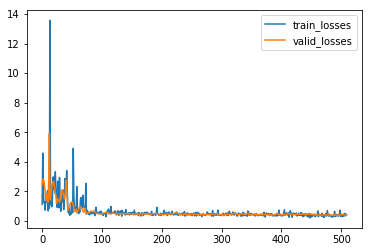

In [29]:
import matplotlib.pyplot as mplot

mplot.plot(train_losses, label='train_losses')
mplot.plot(valid_losses, label='valid_losses')
mplot.legend()
mplot.show()

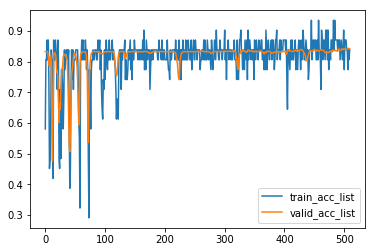

In [30]:
# import matplotlib.pyplot as mplot

mplot.plot(train_acc_list, label='train_acc_list')
mplot.plot(valid_acc_list, label='valid_acc_list')
mplot.legend()
mplot.show()